### Suplemmentary figure requested by Adele. 
#### Same figure as 4.6 that has all Ekman correlations but for zonal and meridional wind stress correlating with the isopycnal depth along the slope and TBOX


## First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [1]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Loading the basics

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [3]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35663/status,
Dashboard: /proxy/35663/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39227,Workers: 7
Dashboard: /proxy/35663/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:44215,Total threads: 4
Dashboard: /proxy/45125/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:41901,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### Creating variables for time series

### temperature

In [5]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)


In [6]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

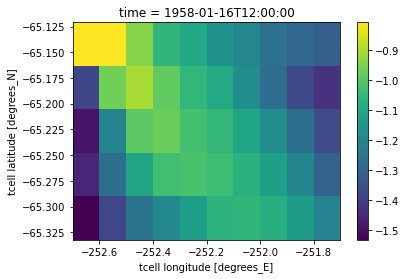

In [7]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [8]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [9]:
temp_400m = temp_400m.load()

#### Detrend time series and apply rolling mean 

In [10]:
# Note we need to first detrend the data:
temp_400m_zadr = detrend_dim(temp_400m,'time')
temp_400m_zadr = temp_400m_zadr.rolling(time=12, center=True).mean()
temp_400m_r = temp_400m.rolling(time=12, center=True).mean()

#### ISOPYCNALS 
##### Cut data loaded on previously, so we don't have t load it again

In [11]:
# ORIGINAL
lon_slice  = slice(-253, -251.5)
lat_slice  = slice(-67.5, -63)

temp_iso = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso = temp_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

sal_iso = cc.querying.getvar(iaf_cycle3,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso = sal_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [12]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

In [13]:
# cut the data BOX 1
#lon_slice  = slice(-253, -251.5) #best
lat_slice  = slice(-65.3, -63)
lon_slice  = slice(-253.5, -251.1)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

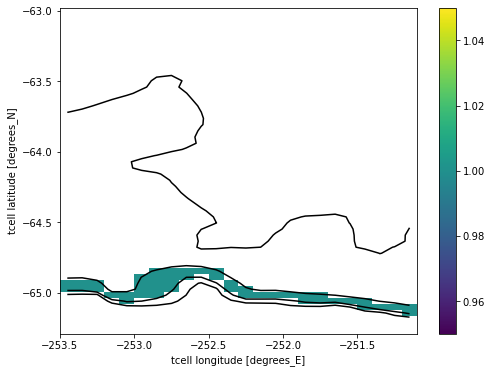

In [14]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [15]:
#apply the mask
sigma0_off = sigma0*region_mask
sigma0_off = sigma0_off.where(sigma0_off!=0)

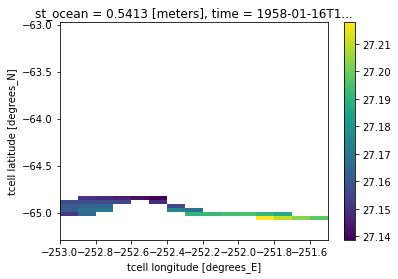

In [16]:
# first time step only:
sigma0_off[0,0,...].plot()

In [ ]:
#load
sigma0_off=sigma0_off.load()

Incorporating Adele's method of calculating isopycnals.
Old method works fine, but averaging across lat/lon first means that your final depth values will be limited to values of st_ocean (i.e. quite discrete and widely spaced).
Try to find first depth where density > rho_thresh (27.82 looks like it might be around 500-600 m, i.e. at the depth of shelf break) at each lat/lon position, then average these depths after over lat/lon, which should make the final depth values have more variable values.

Using only the isopycnals that had the highest correlations with previous variables 27.82 and 27.83

In [ ]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0_off.where(sigma0_off>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0_off*0 + sigma0_off.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0_off>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

# now average that minimum depth over lat and lon:
min_depth_avg = min_depth.mean('xt_ocean').mean('yt_ocean')
min_depth_avg.plot()

#rename the isopycnal
iso2782_dth=min_depth_avg

In [ ]:
#they are still xarrays until I load them
iso2782_dth=iso2782_dth.load()


### Apply rolling mean 

In [ ]:
iso2782_dth_r = iso2782_dth.rolling(time=12, center=True).mean()


## LOAD WIND X & Y TO CALCULATE SPATIAL CORRELATION

### prepare winds (taux)

In [ ]:
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-256, -246)

windX_con = cc.querying.getvar(iaf_cycle3,'tau_x', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
windX_con = windX_con.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                            
windX_con = windX_con.load()


In [ ]:
#rlist = cc.querying.get_variables(master_session, easterlies_up_zonal)
#varlist[varlist['name'].str.lower().str.match('tau')]

### prepare winds (tauy)

In [ ]:
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-256, -246)

windY_con = cc.querying.getvar(iaf_cycle3,'tau_y', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
windY_con = windY_con.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                            
windY_con = windY_con.load()


In [ ]:
windX_con = windX_con.load()

windY_con = windY_con.load()


### still have to detrend the data and roll the mean over it

In [30]:
# Note we need to first detrend the data:
windX_con_detrended = detrend_dim(windX_con,'time')
windX_con_dr = windX_con_detrended.rolling(time=12, center=True).mean()

windY_con_detrended = detrend_dim(windY_con,'time')
windY_con_dr = windY_con_detrended.rolling(time=12, center=True).mean()

### compute correlation

In [33]:
# This computes the cor: era lax=2
cov,cor_isoX,slope,intercept,pval_iso,stderr = lag_linregress_3D(iso2782_dth_r,windX_con_dr,lagx=0, lagy=0)
cov,cor_isoY,slope,intercept,pval_iso,stderr = lag_linregress_3D(iso2782_dth_r,windY_con_dr,lagx=0, lagy=0)

cov,cor_tempX,slope,intercept,pval_iso,stderr = lag_linregress_3D(temp_400m_zadr,windX_con_dr,lagx=2, lagy=0)
cov,cor_tempY,slope,intercept,pval_iso,stderr = lag_linregress_3D(temp_400m_zadr,windY_con_dr,lagx=2, lagy=0)

### Loading Bathymetry for the plots

In [34]:
#have to load this again
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:zzzzzzzzzzzzzzzzzzzzzzzzz
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

### PLOT THE SPATIAL CORR BETWEEN EKMAN AND ISO DEPTH

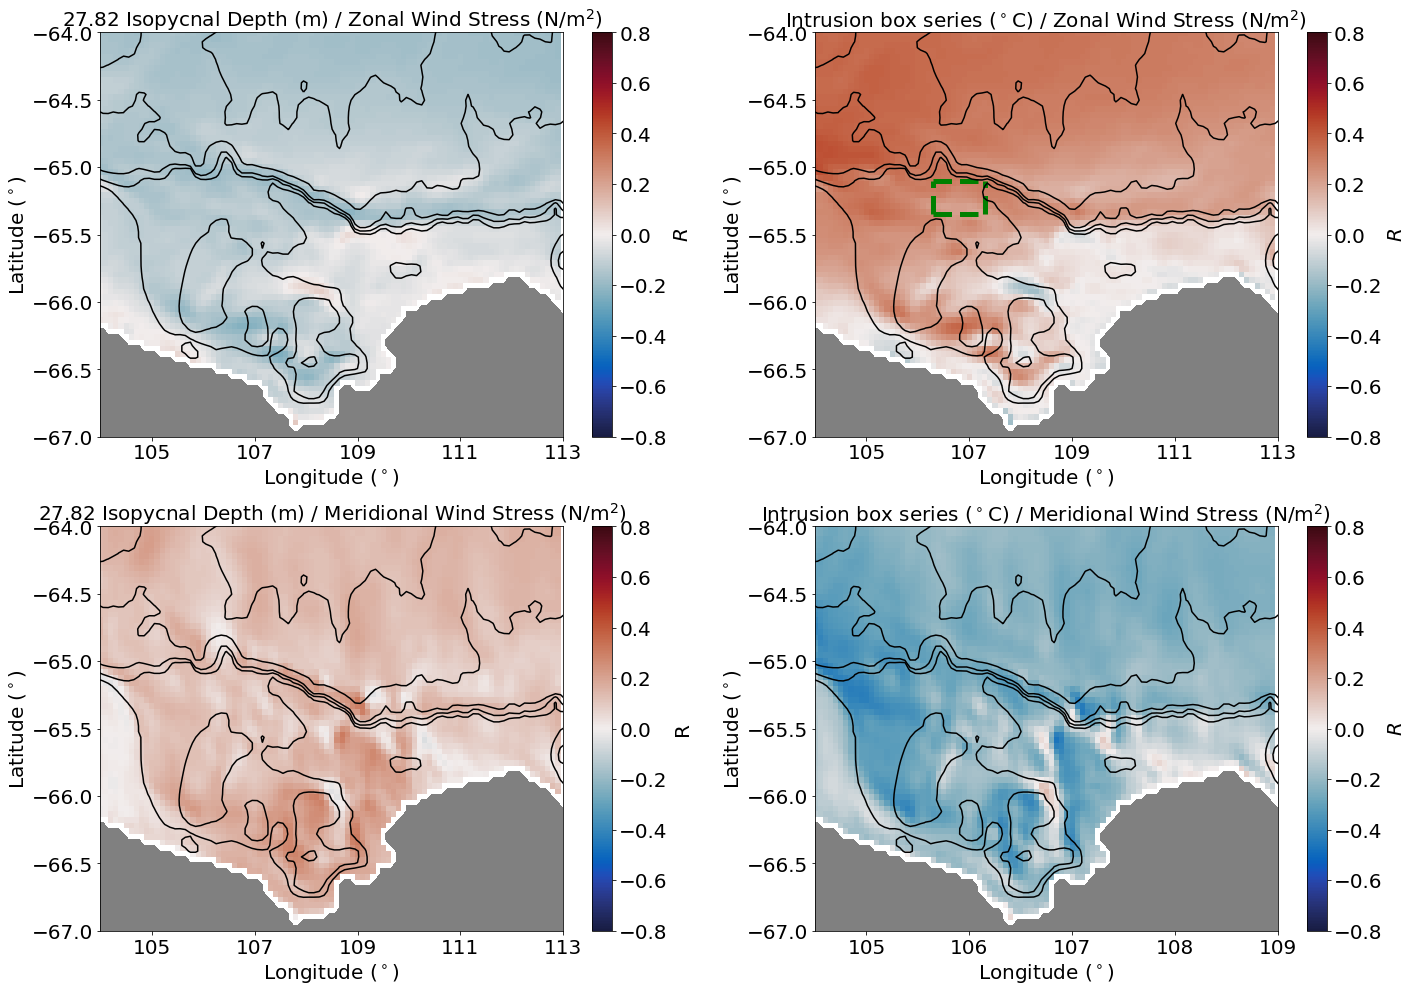

In [37]:
# Plot a map of the correlation at each point:
fontsize=20;
fig = plt.figure(figsize=(20,20))
ax1=plt.subplot(321) 
pc = plt.pcolormesh(cor_isoX.xu_ocean,cor_isoX.yu_ocean,
                        cor_isoX, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='darkorange',linestyle='-',linewidth=3)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[1000,2000],colors='blueviolet',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('27.82 Isopycnal Depth (m) / Zonal Wind Stress (N/m$^{2}$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])

ax1=plt.subplot(322) 
pc = plt.pcolormesh(cor_tempX.xu_ocean,cor_tempX.yu_ocean,
                        cor_tempX, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='green',linestyle='--',linewidth=5)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('Intrusion box series ($^\circ$C) / Zonal Wind Stress (N/m$^{2}$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])


ax1=plt.subplot(323) 
pc = plt.pcolormesh(cor_isoY.xu_ocean,cor_isoY.yu_ocean,
                        cor_isoY, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.set_label('R',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='darkorange',linestyle='-',linewidth=3)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,1000],colors='gray',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('27.82 Isopycnal Depth (m) / Meridional Wind Stress (N/m$^{2}$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax1=plt.subplot(324) 
pc = plt.pcolormesh(cor_tempY.xu_ocean,cor_tempY.yu_ocean,
                        cor_tempY, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('Intrusion box series ($^\circ$C) / Meridional Wind Stress (N/m$^{2}$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])
fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
##figdir = '/g/data/jk72/ns3783'
filestr = figdir+'/Sup_Fig_ch4_spatial_corr_wind.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

